# Shape Classifier: Circles, Squares, and Triangles

A Jupyter Notebook to demonstrate the training and evaluation of a CNN model to classify synthetic images of geometric shapes.

**Project Structure Note:** In adherence to the project requirement for `clean, modular, and well-organized code,` complex helper functions for data generation and visualization are encapsulated in the `ShapeClassifier/utils/` directory. This keeps the main notebook focused on the core machine learning workflow: configuration, data loading, model definition, training, and evaluation.

## 1. Setup & Configuration

This section handles all the initial setup for the project:
*   Importing essential libraries.
*   Defining constants, hyperparameters, and file paths.
*   Setting up reproducibility seeds.

### 1.1. Path Configuration

First, we set up the system path to ensure our utility scripts in the `ShapeClassifier/utils/` directory can be imported reliably. We also define the core paths for our project artifacts.

In [1]:
import os
import sys

# We assume this notebook is run from its location in the 'ShapeClassifier' directory.
# The project root is one level up.
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
    print(f"Added '{PROJECT_ROOT}' to system path.")

# Define core paths relative to the project root for robustness.
ARTIFACTS_DIR = os.path.join(PROJECT_ROOT, '..', 'shape-classifier-artifacts')
DATASET_DIR = os.path.join(ARTIFACTS_DIR, 'shape-classifier-datasets', 'ShapeClassifier')
MODEL_CHECKPOINT_DIR = os.path.join(ARTIFACTS_DIR, 'shape-classifier-models', 'ShapeClassifier')

print(f"Project Root: {PROJECT_ROOT}")
print(f"Dataset Directory: {DATASET_DIR}")

Added 'c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch' to system path.
Project Root: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch
Dataset Directory: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-datasets\ShapeClassifier


### 1.2. Library Imports

Next, we import all the necessary libraries for the project.

In [2]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm

print("Libraries imported successfully.")

Libraries imported successfully.


### 1.3. Constants and Seeding

We define key constants for our project and a function to set seeds for reproducibility. The seeding function is called in a separate cell to prevent it from being re-run unnecessarily when constants are changed.

In [3]:
# --- Constants ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CLASSES = ['circle', 'square', 'triangle']
NUM_CLASSES = len(CLASSES)
MODEL_CHECKPOINT_PATH = os.path.join(MODEL_CHECKPOINT_DIR, 'best_model_checkpoint.pth')


# --- Seeding Function ---
def set_seed(seed=42):
    """Sets the seed for random, numpy, and torch for reproducible results."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Seed set to {seed}")

print(f"Device set to: {DEVICE.upper()}")

Device set to: CUDA


### 1.4. Initial Setup Execution

Here we execute one-time setup commands: we set the global seed and ensure the directory for saving our model checkpoints exists.

In [4]:
# Set the seed for the entire notebook session.
set_seed(42)

# Ensure the directory for saving model checkpoints exists.
os.makedirs(MODEL_CHECKPOINT_DIR, exist_ok=True)
print("Initial setup executed.")

Seed set to 42
Initial setup executed.


## 2. Data Generation & Loading

This section covers preparing the data for the model. It includes:
*   An optional step to regenerate the entire dataset from scratch.
*   Defining a custom PyTorch `Dataset` class to load the images.
*   Applying necessary transformations.
*   Creating `DataLoader`s to feed data to the model in batches.

### 2.1. Optional: Generate Dataset from Scratch

This project is configured to use the pre-generated (or downloaded) dataset located in the `shape-classifier-artifacts` directory.

However, if you wish to regenerate the entire dataset from scratch, you can set the `REGENERATE_DATA` flag in the cell below to `True`.

**>>> Warning:** This process will delete all existing data in the target directory and will take several minutes to complete.

In [5]:
from ShapeClassifier.utils.data_generator import generate_dataset

# --- Configuration for Data Generation ---
REGENERATE_DATA = False # Set to True to run the data generation process.

# These parameters are used ONLY if REGENERATE_DATA is True.
TOTAL_IMAGES_TO_GENERATE = 6000
SPLIT_RATIOS = {'train': 0.7, 'validation': 0.15, 'test': 0.15}


if REGENERATE_DATA:
    # We call our imported function using the path constants defined in Section 1.
    generate_dataset(
        root_dir=DATASET_DIR,
        total_images=TOTAL_IMAGES_TO_GENERATE,
        # root_dir=os.path.join(DATASET_DIR, "Delete"),
        # total_images=100,
        splits=SPLIT_RATIOS,
        shapes=CLASSES # Using the 'CLASSES' constant from Section 1
    )
else:
    print("Skipping data generation. Using existing dataset.")

# Verify that the dataset directory exists.
if not os.path.exists(DATASET_DIR):
    print("\nERROR: Dataset directory not found!")
    print(f"Please run the project's download script or set REGENERATE_DATA to True.")
else:
    print(f"\nDataset found at: {DATASET_DIR}")

Skipping data generation. Using existing dataset.

Dataset found at: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-datasets\ShapeClassifier


### 2.2. PyTorch Dataset Class

To load our data into PyTorch, we need to create a custom `Dataset` class. This class acts as a standardized interface and is responsible for two key things:
1.  `__len__`: Telling PyTorch the total number of images in the dataset.
2.  `__getitem__`: Providing the i-th item from the dataset, which consists of an image and its corresponding label, ready for the model.

Our `ShapeDataset` class will scan a given directory (e.g., `train`, `validation`, or `test`), find all image paths, and infer the correct label from the subdirectory name (e.g., 'circle', 'square').

In [6]:
class ShapeDataset(Dataset):
    """Custom Dataset for loading shape images."""

    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (string): Directory with all the images, organized in subfolders by class.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.image_paths = []
        self.labels = []

        # Walk through the directory to gather image paths and labels
        for cls_name in self.classes:
            class_dir = os.path.join(data_dir, cls_name)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.image_paths[idx]
        # Using .convert('L') ensures the image is loaded as single-channel grayscale
        image = Image.open(img_path).convert('L')
        
        # Get the label
        label = self.labels[idx]

        # Apply transformations if they exist
        if self.transform:
            image = self.transform(image)
            
        return image, label

print("ShapeDataset class defined.")

ShapeDataset class defined.


### 2.3. Calculating Normalization Statistics for Z-Score Standardization

A crucial step in preparing image data for a neural network is **normalization**. Normalization rescales the pixel values to a standard range, which helps the model's optimizer converge faster and more reliably. Without it, the large range of pixel values (0-255) can lead to unstable gradients during training.

While a simple approach is to scale values to a fixed range like `[-1, 1]`, a more robust and widely-used technique is **Z-score standardization**. This method transforms the data so that it has a **mean of 0 and a standard deviation of 1**.

The formula for each pixel is:
$$ z = \frac{x - \mu}{\sigma} $$
where:
- $x$ is the original pixel value
- $\mu$ (mu) is the mean of all pixel values in the dataset
- $\sigma$ (sigma) is the standard deviation of all pixel values

To implement this, we must first calculate the true $\mu$ and $\sigma$ from our data.

**>>> Important:** We only ever calculate these statistics on the **training set**. The validation and test sets must remain "unseen." Using statistics from them would be a form of data leakage, giving our model an unfair preview of the data it will be evaluated on.

In the next cell, we create a temporary dataset with a simple `ToTensor()` transform to iterate through all training images and compute these two values.

In [7]:
# Create a temporary dataset of the training data just for calculating the mean and std
# We only need to convert images to tensors for this calculation.
temp_train_dataset = ShapeDataset(
    data_dir=os.path.join(DATASET_DIR, 'train'), 
    transform=transforms.ToTensor()
)

# Use a DataLoader to iterate through the dataset efficiently.
# Note: `num_workers` is not set. In a Jupyter/IPython environment, especially on
# Windows, using multiple workers for data loading can lead to multiprocessing
# deadlocks. By leaving it at its default (0), data loading occurs in the
# main process, ensuring compatibility.
temp_loader = DataLoader(temp_train_dataset, batch_size=64, shuffle=False)

# Calculate mean and std
mean = 0.
std = 0.
num_samples = 0

print("Calculating mean and standard deviation from the training set...")
# Wrap the loader with tqdm for a progress bar
for images, _ in tqdm(temp_loader, desc="Calculating Stats"):
    # Reshape images to (batch_size, num_pixels) and count samples
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    # Update mean and std
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    num_samples += batch_samples

mean /= num_samples
std /= num_samples

print(f"\nCalculated Mean: {mean.item():.4f}")
print(f"Calculated Std: {std.item():.4f}")

# --- Clean up temporary objects ---
# We no longer need these, so we can free up memory.
del temp_loader, temp_train_dataset
print("\nTemporary objects for calculation have been cleaned up.")

Calculating mean and standard deviation from the training set...


Calculating Stats:   0%|          | 0/66 [00:00<?, ?it/s]


Calculated Mean: 0.5091
Calculated Std: 0.2448

Temporary objects for calculation have been cleaned up.


### 2.4. Defining the Final Image Transformation Pipelines

Now that we have the exact mean and standard deviation of our training data, we can build our final transformation pipelines. We use `torchvision.transforms.Compose` to chain together multiple operations.

Our pipeline will consist of two steps:
1.  `transforms.ToTensor()`: This is a critical first step. It converts the PIL Image, which is a grid of pixels with values from `[0, 255]`, into a PyTorch FloatTensor. It also automatically scales the pixel values to a range of `[0.0, 1.0]`.
2.  `transforms.Normalize(mean, std)`: This takes the `[0.0, 1.0]` tensor from the previous step and applies the Z-score formula ($z = (x - \mu) / \sigma$), using the `mean` and `std` we just calculated.

We create two separate pipelines. Although they are identical in this case, it is good practice to distinguish between them. In more complex projects, the training pipeline might include additional data augmentation steps (like random rotations or flips) that should not be applied to the validation or test data.

In [8]:
# Define the final transformations for our datasets using the calculated stats.
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val_test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

print("Data transformations defined with calculated mean and std.")

Data transformations defined with calculated mean and std.


### 2.5. Create Final Datasets and DataLoaders

With our `ShapeDataset` class defined and our `data_transforms` ready, we can now create the final dataset instances for our training, validation, and test splits.

These `Dataset` objects are then wrapped by a `DataLoader`. The `DataLoader` is a powerful PyTorch utility that handles:
-   **Batching:** Grouping individual data points into mini-batches of a specified size.
-   **Shuffling:** Randomly shuffling the training data at the beginning of each epoch to prevent the model from learning the order of the data.
-   **Parallel Loading:** (Which we have disabled for notebook compatibility) Loading data in the background.

In [9]:
# --- Hyperparameters for DataLoaders ---
# We define BATCH_SIZE here to keep all hyperparameters in one place,
# but it's used in this section.
BATCH_SIZE = 32

# Create Dataset instances for each split, applying the correct transforms
image_datasets = {
    'train': ShapeDataset(os.path.join(DATASET_DIR, 'train'), transform=data_transforms['train']),
    'validation': ShapeDataset(os.path.join(DATASET_DIR, 'validation'), transform=data_transforms['val_test']),
    'test': ShapeDataset(os.path.join(DATASET_DIR, 'test'), transform=data_transforms['val_test'])
}

# Create DataLoader instances for each split
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True),
    'validation': DataLoader(image_datasets['validation'], batch_size=BATCH_SIZE, shuffle=False),
    'test': DataLoader(image_datasets['test'], batch_size=BATCH_SIZE, shuffle=False)
}

# Store dataset sizes for later use
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}
class_names = image_datasets['train'].classes

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

Dataset sizes: {'train': 4200, 'validation': 900, 'test': 900}
Class names: ['circle', 'square', 'triangle']


### 2.6. Visualize a Batch of Training Data

As a final sanity check, let's visualize a few images from a single training batch. This helps us confirm that:
-   The images are being loaded correctly.
-   The labels are accurate.
-   The normalization has been applied (note that the colors may look unusual because the pixel values have been shifted and scaled).

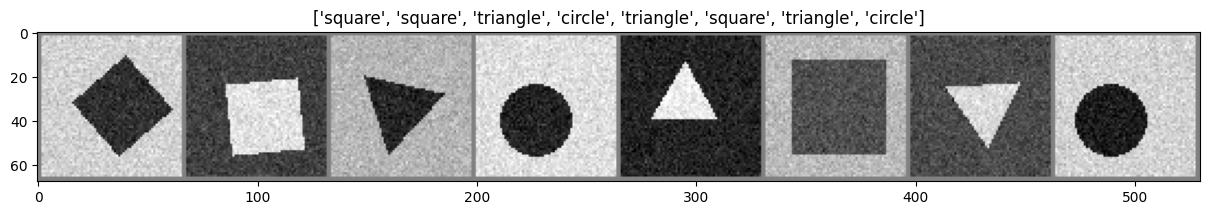

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    # The normalization was (x - mean) / std. To reverse it, we do x * std + mean.
    inp = inp.numpy().transpose((1, 2, 0))
    mean_np = np.array([mean.item()])
    std_np = np.array([std.item()])
    inp = std_np * inp + mean_np
    inp = np.clip(inp, 0, 1) # Clip values to be in the valid [0, 1] range
    plt.imshow(inp, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes_idx = next(iter(dataloaders['train']))

# Make a grid from the batch
# We use torchvision.utils.make_grid for this
import torchvision
out = torchvision.utils.make_grid(inputs[:8]) # Show the first 8 images

# Set up the plot
plt.figure(figsize=(15, 10))
imshow(out, title=[class_names[x] for x in classes_idx[:8]])

## 3. Model Architecture

Here, we define the architecture of our Convolutional Neural Network (CNN) and provide the justification for this choice.

## 4. Training the Model

This section contains the logic for training the model, including:
*   Defining the loss function and optimizer.
*   Implementing the training and validation loops.
*   Incorporating early stopping and model checkpointing to save the best-performing model.

## 5. Evaluation

After training, we evaluate the model's performance on the unseen test set. This includes:
*   Loading the best model checkpoint.
*   Calculating final test accuracy.
*   Visualizing a confusion matrix and sample predictions.

## 6. Analysis & Conclusion

A final summary of the results, including:
*   Plotting the training/validation curves.
*   Answering the project questions on learnings and potential improvements.